### Stock Market Prediction And Forecasting Using Stacked LSTM

In [209]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import tensorflow as tf
tf.__version__
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [207]:
stock = 'AAPL'
key="9f99e4e180cefcfd9422cf227da2679cfffb57e8"
df = pdr.get_data_tiingo(stock, api_key=key)
df.to_csv('stock.csv')

<ipython-input-207-08eea646c44b>:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pdr.get_data_tiingo(stock, api_key=key)


In [133]:
stock_data=df.reset_index()['close']

In [134]:
stock_data

0       187.50
1       186.87
2       190.24
3       191.83
4       193.31
         ...  
1253    174.20
1254    171.56
1255    171.84
1256    172.99
1257    175.43
Name: close, Length: 1258, dtype: float64

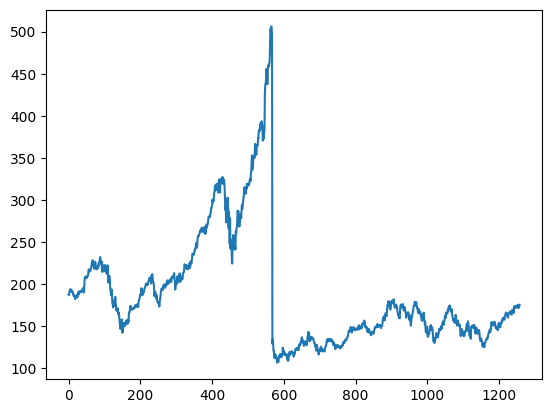

In [135]:
import matplotlib.pyplot as plt
plt.plot(stock_data)

In [141]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
stock_data=scaler.fit_transform(np.array(stock_data).reshape(-1,1))

In [142]:
# print(df1)

In [143]:
##splitting dataset into train and test split
training_size=int(len(stock_data)*0.65)
test_size=len(stock_data)-training_size
train_data,test_data=stock_data[0:training_size,:],stock_data[training_size:len(stock_data),:1]

In [144]:
training_size,test_size

(817, 441)

In [145]:
#train_data

In [146]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [147]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [148]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [149]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [150]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [151]:
### Create the Stacked LSTM model

In [152]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [153]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_10 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [155]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
12/12 [==============================] - 9s 266ms/step - loss: 0.0355 - val_loss: 4.8933e-04
Epoch 2/10
12/12 [==============================] - 2s 131ms/step - loss: 0.0174 - val_loss: 0.0061
Epoch 3/10
12/12 [==============================] - 2s 130ms/step - loss: 0.0110 - val_loss: 6.7091e-04
Epoch 4/10
12/12 [==============================] - 2s 184ms/step - loss: 0.0097 - val_loss: 3.8614e-04
Epoch 5/10
12/12 [==============================] - 2s 126ms/step - loss: 0.0093 - val_loss: 0.0012
Epoch 6/10
12/12 [==============================] - 2s 131ms/step - loss: 0.0086 - val_loss: 0.0010
Epoch 7/10
12/12 [==============================] - 2s 129ms/step - loss: 0.0071 - val_loss: 4.8812e-04
Epoch 8/10
12/12 [==============================] - 2s 129ms/step - loss: 0.0063 - val_loss: 3.6811e-04
Epoch 9/10
12/12 [==============================] - 2s 138ms/step - loss: 0.0057 - val_loss: 3.4822e-04
Epoch 10/10
12/12 [==============================] - 2s 135ms/step - loss: 0

In [156]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 26ms/step


In [157]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [158]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

227.16459896797755

In [159]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

161.80400551591185

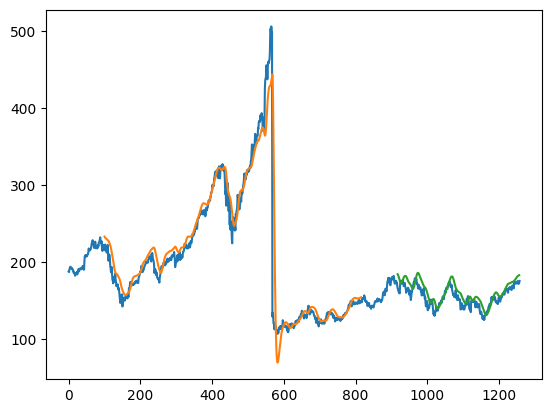

In [160]:
### Plotting 
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = numpy.empty_like(stock_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(stock_data)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(stock_data)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(stock_data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [161]:
len(test_data)

441

In [162]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape


(1, 100)

In [163]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [165]:
#temp_input
days = 30
n_steps=100

In [167]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
i=0
while(i<days):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

# print(lst_output)

0 day input [0.11739512 0.11448967 0.10429555 0.10537257 0.10659987 0.09986224
 0.10289292 0.10161553 0.09635567 0.09785848 0.11068253 0.11769568
 0.11211021 0.11529117 0.10958046 0.10434565 0.1092799  0.11458986
 0.11559173 0.12275517 0.12062617 0.12663745 0.13134627 0.12771446
 0.13046963 0.13377583 0.12884158 0.12726362 0.13507827 0.13906074
 0.14542267 0.14860363 0.1472511  0.14256731 0.14482154 0.13823419
 0.13515341 0.13340013 0.14707577 0.14619912 0.14624922 0.14935504
 0.15226049 0.14980589 0.14572323 0.14649969 0.14259236 0.14256731
 0.15421415 0.15739512 0.15716969 0.15453976 0.15180964 0.14765185
 0.16713838 0.16696306 0.16262993 0.16710081 0.16758923 0.16463369
 0.16338134 0.16338134 0.16493425 0.17084534 0.17112085 0.16871634
 0.16210394 0.16280526 0.16568566 0.17179712 0.19079775 0.19146059
 0.19288771 0.1950841  0.19795214 0.2013569  0.20516552 0.20926616
 0.2135745  0.21803243 0.22260371 0.22726767 0.23201445 0.23684032
 0.24174488 0.2467286  0.25179246 0.25693661 0.262

In [168]:
day_new=np.arange(1,time_step +1)
day_pred=np.arange(time_step +1,time_step +1 + days)

In [170]:
len(stock_data)

1258

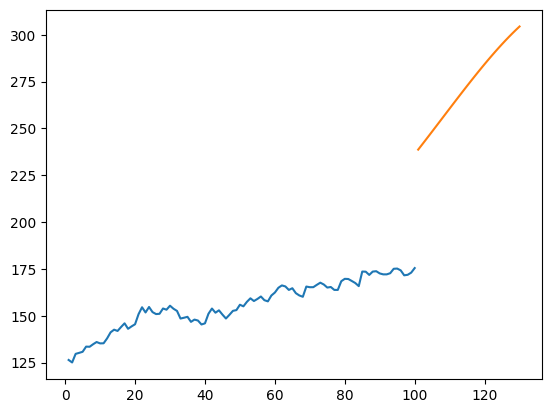

In [171]:
plt.plot(day_new,scaler.inverse_transform(stock_data[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

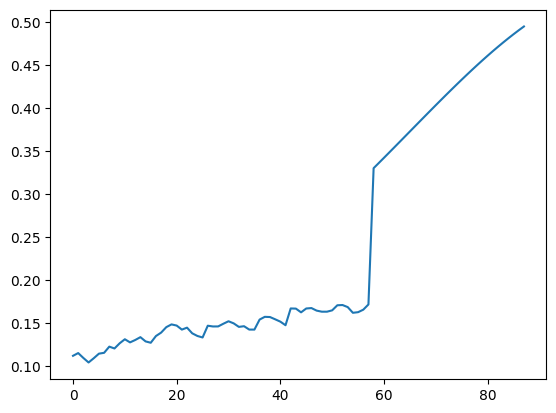

In [173]:
stock_data_merged=stock_data.tolist()
stock_data_merged.extend(lst_output)
plt.plot(stock_data_merged[1200:])

In [174]:
stock_data_merged=scaler.inverse_transform(stock_data_merged).tolist()

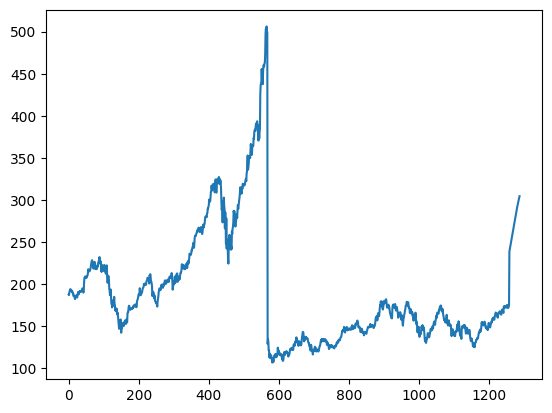

In [175]:
plt.plot(stock_data_merged)

In [179]:
from datetime import datetime, timedelta

def generate_dates(start_date, n):
    dates = []
    current_date = start_date
    
    for _ in range(n):
        dates.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    
    return dates

# Example usage
start_date = datetime(2023, 5, 31)  # Specify the start date
n = 10  # Specify the number of days

pred_date_list = generate_dates(start_date, n)
print(pred_date_list)


['2023-05-31', '2023-06-01', '2023-06-02', '2023-06-03', '2023-06-04', '2023-06-05', '2023-06-06', '2023-06-07', '2023-06-08', '2023-06-09']


In [208]:
# original_dates = df['date'].to_list()
# original_dates


In [202]:
predicted_values = scaler.inverse_transform(lst_output)
# predicted_values

In [217]:
model.save('models/{}_stock-100_epochs.h5'.format(stock))

In [223]:
#tflite
model_for_lite = tf.keras.models.load_model('models/{}_stock-100_epochs.h5'.format(stock))
# converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_lite)
converter.experimental_new_converter = True


In [222]:
tflite_model = converter.convert()
# open("models/APPl_stock-100_epochs.tflite","wb").write(tflite_model)

with open("models/APPl_stock-100_epochs.tflite","wb") as f:
    f.write(tflite_model)

ConverterError: ignored